In [2]:
import h5py

h5_path = "/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/2022_Engineering_2022042014_R10C_P3C1_L1_Spectrometer_RadianceH5_2022042014_NEON_D10_R10C_DP1_20220420_L001-2_radiance.h5"  # Replace with the path to your flightline

with h5py.File(h5_path, 'r') as f:
    def print_h5_structure(name, obj):
        print(name)
    f.visititems(print_h5_structure)


R10C
R10C/Radiance
R10C/Radiance/Metadata
R10C/Radiance/Metadata/Ancillary_Rasters
R10C/Radiance/Metadata/Ancillary_Rasters/BDE
R10C/Radiance/Metadata/Ancillary_Rasters/GLT_Data
R10C/Radiance/Metadata/Ancillary_Rasters/IGM_Data
R10C/Radiance/Metadata/Ancillary_Rasters/OBS_Data
R10C/Radiance/Metadata/Coordinate_System
R10C/Radiance/Metadata/Coordinate_System/Coordinate_System_String
R10C/Radiance/Metadata/Coordinate_System/EPSG Code
R10C/Radiance/Metadata/Coordinate_System/Map_Info
R10C/Radiance/Metadata/Coordinate_System/Proj4
R10C/Radiance/Metadata/Flight_Trajectory
R10C/Radiance/Metadata/Flight_Trajectory/Flight_Altitude
R10C/Radiance/Metadata/Flight_Trajectory/Flight_Heading
R10C/Radiance/Metadata/Flight_Trajectory/Flight_Time
R10C/Radiance/Metadata/QAQC
R10C/Radiance/Metadata/Spectral_Data
R10C/Radiance/Metadata/Spectral_Data/FWHM
R10C/Radiance/Metadata/Spectral_Data/Wavelength
R10C/Radiance/RadianceDecimalPart
R10C/Radiance/RadianceIntegerPart


In [3]:
from spectral import open_image

img = open_image('/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_rad.hdr')
print("Shape:", img.shape)  # (lines, samples, bands)


Shape: (5153, 951, 426)


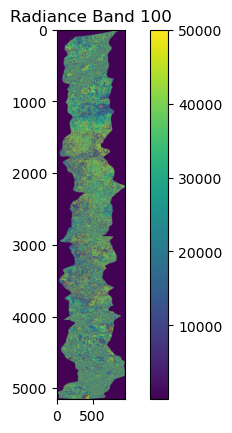

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img[:, :, 100], cmap='viridis')
plt.title("Radiance Band 100")
plt.colorbar()
plt.show()

In [9]:
import h5py
import numpy as np

with h5py.File(h5_path, 'r') as f:
    obs_array = f['R10C']['Radiance']['Metadata']['Ancillary_Rasters']['OBS_Data'][()]

for i in range(obs_array.shape[-1]):
    band = obs_array[:, :, i]
    print(f"Band {i}: min={band.min():.2f}, max={band.max():.2f}, mean={band.mean():.2f}")



Band 0: min=-9999.00, max=1163.45, mean=-3206.60
Band 1: min=-9999.00, max=359.99, mean=-3724.57
Band 2: min=-9999.00, max=25.65, mean=-3821.74
Band 3: min=-9999.00, max=121.82, mean=-3752.58
Band 4: min=-9999.00, max=43.02, mean=-3801.14
Band 5: min=-9999.00, max=63.70, mean=-3801.96
Band 6: min=-9999.00, max=82.55, mean=-3825.24
Band 7: min=-9999.00, max=360.00, mean=-3751.99
Band 8: min=-9999.00, max=1.00, mean=-3827.17
Band 9: min=-9999.00, max=16.60, mean=-3817.38


In [12]:
import h5py
import numpy as np
from spectral.io import envi

h5_path = h5_path

with h5py.File(h5_path, 'r') as f:
    obs_full = f['R10C']['Radiance']['Metadata']['Ancillary_Rasters']['OBS_Data'][()]

    # Apply band mappings based on stats above
    sensor_zenith = obs_full[:, :, 2]
    sensor_azimuth = obs_full[:, :, 1]
    solar_zenith = obs_full[:, :, 3]
    solar_azimuth = obs_full[:, :, 7]
    path_length = obs_full[:, :, 0]
    cosine_i = obs_full[:, :, 8]

    # Stack into 6-band obs array
    obs_array = np.stack([
        sensor_zenith,
        sensor_azimuth,
        solar_zenith,
        solar_azimuth,
        path_length,
        cosine_i
    ], axis=-1).astype(np.float32)

# Replace fill values (-9999) with np.nan or 0.0 if needed
obs_array[obs_array == -9999] = np.nan  # or 0.0

# Save to ENVI BIL format
output_meta = {
    'lines': obs_array.shape[0],
    'samples': obs_array.shape[1],
    'bands': obs_array.shape[2],
    'interleave': 'bil',
    'data type': 4,
    'byte order': 0
}

envi.save_image('/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c.obs.hdr', obs_array, dtype=np.float32, interleave='bil', force=True, metadata=output_meta)


In [13]:
from spectral.io.envi import read_envi_header

hdr_path = "/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_rad.hdr"
header = read_envi_header(hdr_path)

# Inspect contents
print(header.keys())
print("Samples:", header['samples'])
print("Lines:", header['lines'])
print("Map Info:", header['map info'])


dict_keys(['samples', 'lines', 'bands', 'header offset', 'file type', 'data type', 'interleave', 'byte order', 'map info', 'wavelength', 'fwhm'])
Samples: 951
Lines: 5153
Map Info: ['UTM', '1.000', '1.000', '478685.000', '4444914.000', '1.0000000000e+000', '1.0000000000e+000', '13', 'North', 'WGS-84', 'units=Meters', '0']


In [14]:
def parse_envi_header(path):
    with open(path, 'r') as f:
        lines = f.readlines()

    header = {}
    for line in lines:
        line = line.strip()
        if '=' in line:
            key, val = line.split('=', 1)
            key = key.strip().lower()
            val = val.strip().strip('{}').strip()
            if ',' in val:
                val = [v.strip() for v in val.split(',')]
                try:
                    val = [float(v) if '.' in v or 'e' in v.lower() else int(v) for v in val]
                except:
                    pass
            else:
                try:
                    val = float(val) if '.' in val or 'e' in val.lower() else int(val)
                except:
                    pass
            header[key] = val
    return header

hdr_path = "/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_rad.hdr"
header = parse_envi_header(hdr_path)

print(header['samples'])
print(header['lines'])
print(header['map info'])


951
5153
['UTM', '1.000', '1.000', '478685.000', '4444914.000', '1.0000000000e+000', '1.0000000000e+000', '13', 'North', 'WGS-84', 'units=Meters', '0']


In [16]:
samples = header['samples']
lines = header['lines']

map_info = header['map info']
x_start = map_info[3]
y_start = map_info[4]
pixel_size_x = map_info[5]
pixel_size_y = map_info[6]  # negative for top-down imagery


In [20]:
import numpy as np
from spectral.io import envi
from spectral.io.envi import read_envi_header

def generate_loc_from_hdr(hdr_path, output_path):
    """
    Generate a .loc file (ENVI BIL format) using map info from a .hdr file.
    
    Parameters:
        hdr_path (str): Path to the ENVI .hdr file
        output_path (str): Path prefix (no extension) for the .loc file to write
    """
    # --- Read and sanitize header values ---
    header = read_envi_header(hdr_path)

    samples = int(header['samples'])
    lines = int(header['lines'])

    # Clean and parse map info values
    map_info = header['map info']
    x_start = float(map_info[3])
    y_start = float(map_info[4])
    pixel_size_x = float(map_info[5])
    pixel_size_y = -float(map_info[6])  # negative for row progression (north to south)

    # --- Create coordinate grid ---
    x_coords = x_start + np.arange(samples, dtype=np.float32) * pixel_size_x
    y_coords = y_start + np.arange(lines, dtype=np.float32) * pixel_size_y
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Stack X and Y into 2-band image (lines, samples, 2)
    loc_array = np.stack([xx, yy], axis=-1).astype(np.float32)

    # --- Write ENVI file ---
    output_meta = {
        'lines': lines,
        'samples': samples,
        'bands': 2,
        'interleave': 'bil',
        'data type': 4,  # float32
        'byte order': 0,
        'map info': map_info
    }

    envi.save_image(f"{output_path}.hdr", loc_array, dtype=np.float32, interleave='bil', force=True, metadata=output_meta)
    print(f"✅ Wrote .loc file to: {output_path}.hdr and {output_path}")


In [21]:
generate_loc_from_hdr("/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_rad.hdr", "/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_loc")


✅ Wrote .loc file to: /Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_loc.hdr and /Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_loc


In [23]:
from spectral import open_image

rad = open_image("/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_rad.hdr")
loc = open_image("/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c_loc.hdr")
obs = open_image("/Users/kitlewers/ISOFIT-NEON-H5-CONVERSIONS/imagery/bil/r10c.obs.hdr")

print("rad shape:", rad.shape)
print("loc shape:", loc.shape)
print("obs shape:", obs.shape)


rad shape: (5153, 951, 426)
loc shape: (5153, 951, 2)
obs shape: (5153, 951, 6)
